# Predicting Car Speed from Dashcam Video

My approach will be to calculate optical flow between pairs of successive frames and use that as a metric to predict the car speed via a CNN. 

A general outline of what we'll be doing:

1. Split up given data into training & test
2. Preprocess frames
    * Augment training frames with regularized illumination factor
    * Crop noise out of the frame (car dashboard, etc.) 
    * Interpolate image to input size of neural network
3. Train, validate, hyperparameterize CNN



### Imports

In [1]:
from pyflow import pyflow
import skvideo.io
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2
from matplotlib import pyplot as plt
import numpy as np
import shutil


VIDEO_FP = "/Users/shivam/dev/comma/data/train.mp4"
TEST_VIDEO_FP = "/Users/shivam/dev/comma/data/test.mp4"
SPEEDS_FP = "/Users/shivam/dev/comma/data/train.txt"
NUM_FRAMES = 20400

# Folder names
MAIN = "main"
VALIDATION = "validation"
EVALUATION = "evaluation"
TRAIN = "train"

# Model input size
N_img_height = 66
N_img_width = 220
N_img_channels = 3

## Preprocessing

### Construct Dataset

Let's split the video into frames & save them as images in a seperate folder. 

This way we don't need to have the entire video in memory.

In [2]:
def create_empty_folder(target_folder):
    if os.path.exists(target_folder):
        shutil.rmtree(target_folder)
        
    os.mkdir(target_folder)
    
def get_image_path(folder, num_frame):
    return os.path.join(folder, str(num_frame) + '.jpg')

def load_image(image_path):
    bgr_img = cv2.imread(image_path)
    rbg_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    return rbg_img

def construct_dataset(video_fp, target_folder, num_frames):
    
    create_empty_folder(target_folder)
    
    video_frames = skvideo.io.vreader(video_fp)
    
    for idx, frame in enumerate(tqdm_notebook(video_frames, total=num_frames)):
        img_path = get_image_path(target_folder, idx)
        skvideo.io.vwrite(img_path, frame)

In [3]:
construct_dataset(VIDEO_FP, MAIN, NUM_FRAMES)

Let's also read in the speed data.

Since we atleast need two frames to determine speed, we won't consider the speed of the first frame a valid training point since it has no prior frame. As such, we'll drop it from the dataframe. We will use the average speed between two successive frames as the output.

In [4]:
def speeds_to_df(speeds_fp):
    speeds_df = pd.read_csv(speeds_fp, header=None)
    speeds_df.columns = ['speed']
    speeds_df['speed'] = speeds_df['speed'].rolling(2).mean()
    speeds_df.drop(speeds_df.index[0], inplace=True) 
    return speeds_df

speeds_df = speeds_to_df(SPEEDS_FP)
speeds_df.head()

speed
1  28.105569
2  28.106048
3  28.118465
4  28.119823
5  28.098907

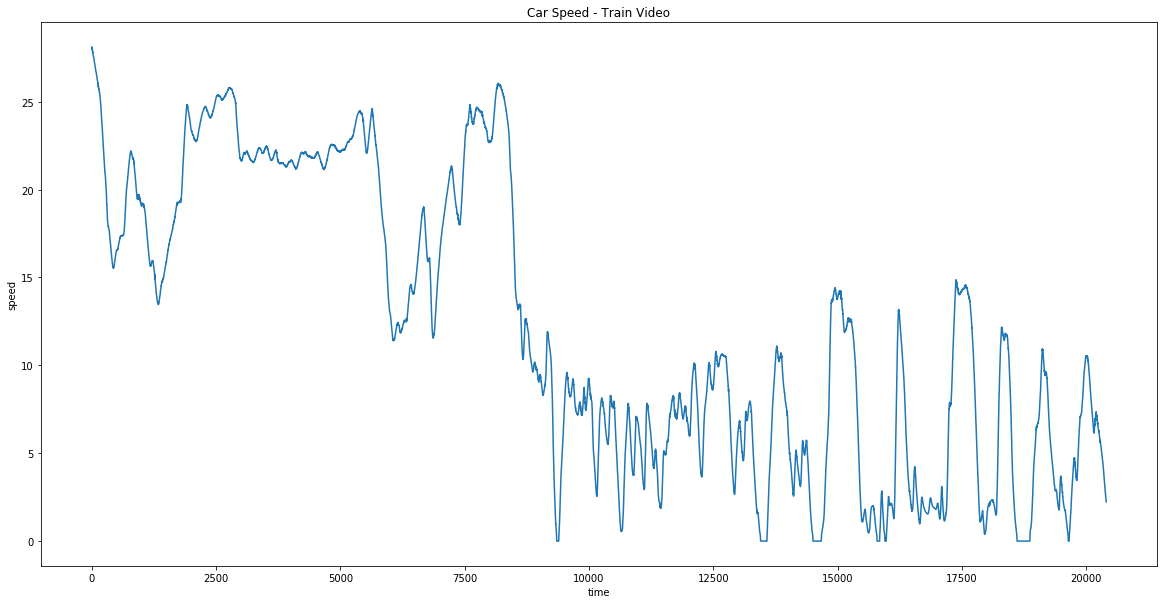

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(speeds_df)
plt.xlabel('time')
plt.ylabel('speed')
plt.title('Car Speed - Train Video')
plt.show()

### Cropping

Let's take a look at what we can remove from the image (sky, dashboard, etc.)

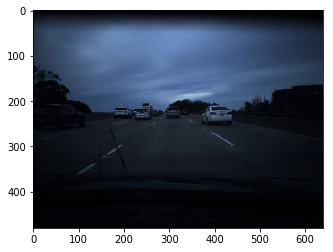

In [ ]:
def custom_crop(image):
    cropped_image = image[80:350, ...]
    return cropped_image

crop_dummy = load_image(get_image_path(MAIN, 1400))
plt.imshow(crop_dummy)

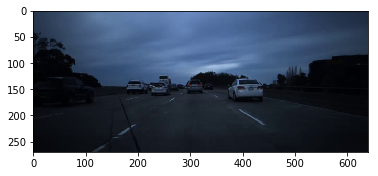

In [ ]:
plt.imshow(custom_crop(crop_dummy))

### Testing Optical Flow

I want to try calculating dense optical flow in two methods:

1. Farneback Method
2. C. Liu. Method detailed in 

C. Liu. Beyond Pixels: Exploring New Representations and Applications for Motion Analysis. Doctoral Thesis. Massachusetts Institute of Technology. May 2009

In [ ]:
def calculate_liu_optical_flow(img_1, img_2):
    alpha = 0.012
    ratio = 0.75
    minWidth = 20
    nOuterFPIterations = 7
    nInnerFPIterations = 1
    nSORIterations = 10
    colType = 0
    
    im_1 = np.array(img_1).astype(float) / 255.
    im_2 = np.array(img_2).astype(float) / 255.
    
    u, v, im2W = pyflow.coarse2fine_flow(
        im_1, im_2, alpha, ratio, minWidth, nOuterFPIterations, nInnerFPIterations,
        nSORIterations, colType)
    
    hsv = np.zeros(img_2.shape, dtype=np.uint8)

    # take saturation values from second image
    #hsv[:, :, 1] = cv2.cvtColor(img_2, cv2.COLOR_RGB2HSV)[:,:,1]
    hsv[:, :, 1] = 255
    
    mag, ang = cv2.cartToPolar(u, v)

    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    return rgb

def calculate_farneback_optical_flow(image_current, image_next):
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    
    hsv = np.zeros(image_next.shape, dtype=np.uint8)
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[...,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to int32's
    #hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    
    return rgb_flow

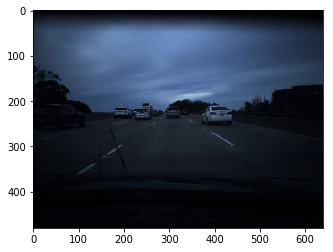

In [ ]:
A = load_image(get_image_path(MAIN, 1400))
B = load_image(get_image_path(MAIN, 1401))
plt.imshow(A)

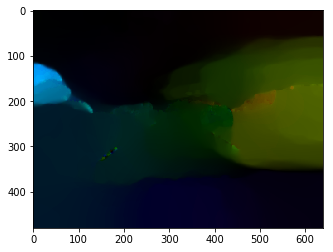

In [ ]:
C = calculate_liu_optical_flow(A, B)
plt.imshow(C)

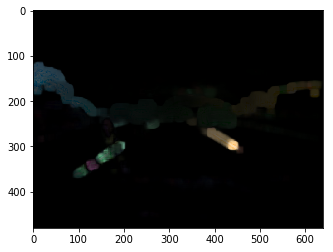

In [ ]:
D = calculate_farneback_optical_flow(A, B)
plt.imshow(D)

The farneback method is much faster. On top of that, it looks like it's better at picking up flow vectors from static markers. These flow vectors are more important than those from noise like cars, etc. as there are more variables affecting the flow vectors of other moving objects than static markers. In fact, if we wanted to do better, we should find a way of identifying flow vectors from static objects & give more weight to those. 

We should also take some more knowledge of the real world and apply as that as a heuristic to filter noise. For instance, if the camera moves in space towards any point in the field of view then the flow vectors from static objects should all intersect at that point. 

A visual example:

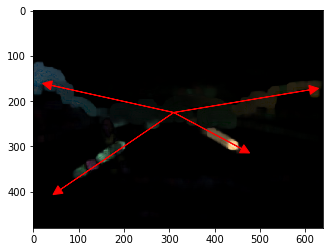

In [ ]:
plt.imshow(D)
plt.arrow(310,225, -270, -60, color="red", head_width=20, head_length=20)
plt.arrow(310,225, 150, 80, color="red", head_width=20, head_length=20)
plt.arrow(310,225, -250, 170, color="red", head_width=20, head_length=20)
plt.arrow(310,225, 300, -50, color="red", head_width=20, head_length=20)

We would expect this kind of analysis to remove the vectors from the cars in the image. However, we don't always have this intersection in our field of view. Sometimes the car can be turning fast & the camera moves towards a point it does not have in its FOV. So, we would apply this heuristic with the appropriate precautions.

Before going deep into this, I'd like to have a baseline model & then apply this kind of analysis if it performs poorly. Let's start by creating our test & train data.

### Data -> Train / Validation / Evaluation

From the data for which we know the speeds, we will split it into training, validation, and evaluation data.

We will train the model on training, cross validate & tune with validation, and then finally evaluate performance on the evaluation set. 

We can randomly shuffle the available training frames into these three sets, but I don't think that's good enough. It's quite likely that most of the evaluation and validation sets will not be contigious. This means the model will have already seen small bits and pieces of very similar environments. I want to set aside about 30% of the validation & evaluation sets as continious frames. 

In [ ]:
def split_dataset(df, split):
    continuous_train_df , continuous_test_df = train_test_split(df, test_size=0.05, shuffle=False, random_state=46)
    train_df, shuffle_test_df = train_test_split(continuous_train_df, test_size=split, random_state=46)
    
    test_df = pd.concat([shuffle_test_df, continuous_test_df])
    
    return train_df, test_df

train_df, evaluation_df = split_dataset(speeds_df, 0.10)
train_df, validation_df = split_dataset(train_df, 0.20)

# Sanity Check; this should give us the number of training points available
print(train_df.shape[0] + evaluation_df.shape[0] + validation_df.shape[0])

20399


Now, we can process pairs of successive frames to build the train, validation, and evaluation sets. 
We will crop the frames, calculate optical flow, and resize the result to the input size of our neural network. 
The one difference that sets apart the train set is that pairs of images should be augmented by an illumination factor to regularize against brightness changes.

In [ ]:
def custom_resize(image):
    resized_image = cv2.resize(image, (N_img_width, N_img_height), interpolation = cv2.INTER_AREA)
    return resized_image

def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

def construct_optical_flow_dataset(frames_df, dataset_folder, target_folder, augment_brightness=False):
    
    create_empty_folder(target_folder)
    
    for idx, row in tqdm_notebook(frames_df.iterrows(), total=frames_df.shape[0]):
        curr_img_path = get_image_path(dataset_folder, idx)
        preceding_img_path = get_image_path(dataset_folder, idx - 1)
        
        curr_img = load_image(curr_img_path)
        preceding_img = load_image(preceding_img_path)
        
        curr_img = custom_crop(curr_img)
        preceding_img = custom_crop(preceding_img)
        
        if augment_brightness:
            bright_factor = np.random.uniform(0,1.3)
            curr_img = change_brightness(curr_img, bright_factor)
            preceding_img = change_brightness(preceding_img, bright_factor)
            
        flow = calculate_farneback_optical_flow(preceding_img, curr_img)
        
        flow = custom_resize(flow)
        
        curr_flow_path = os.path.join(target_folder, str(idx) + '.npy')
        np.save(curr_flow_path, flow)

In [ ]:
construct_optical_flow_dataset(train_df, MAIN, TRAIN, True)

In [ ]:
construct_optical_flow_dataset(validation_df, MAIN, VALIDATION)

In [ ]:
construct_optical_flow_dataset(evaluation_df, MAIN, EVALUATION)

It's much faster to precompute the flow values and then use the generator below to feed training & validation samples to the neural net. The reason for this is because the network will reuse the same images many times, resulting in unneccessary recomputation of flow values. It's best to precompute all these, rather than have them in memory or generate them on the fly each time. 

In [ ]:
def generate_samples(dataset_folder, df, batch_size=16):
    input_batch = np.zeros((batch_size, N_img_height, N_img_width, 3))
    output_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            data_idx = np.random.randint(0, len(df) - 1)
            row = df.iloc[data_idx]
            flow_path = os.path.join(dataset_folder, str(row.name) + '.npy')
            flow = np.load(flow_path)
            input_batch[i] = flow
            output_batch[i] = row['speed']
    
        yield (input_batch, output_batch)

## Model Training

In [ ]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF




def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()

    model.add(Lambda(lambda x: x / 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())
    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
filepath = 'model-weights-Vtest3.h5'

earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=1, 
                              verbose=1, 
                              min_delta = 0.23,
                              mode='min',)

modelCheckpoint = ModelCheckpoint(filepath, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                 save_weights_only = True)
callbacks_list = [modelCheckpoint, earlyStopping]

In [ ]:
train_generator = generate_samples(TRAIN, train_df)
validation_generator = generate_samples(VALIDATION, validation_df, 1)
model = nvidia_model()
history = model.fit_generator(
        train_generator, 
        steps_per_epoch = 400, 
        epochs = 25,
    callbacks = callbacks_list,
        verbose = 1,
        validation_data = validation_generator,
        validation_steps = len(validation_df) - 1)

print(history)

In [ ]:
validation_generator = generate_samples(VALIDATION, validation_df, 1)

In [ ]:
next(validation_generator)

In [ ]:
validation_df.iloc[0].name